#  <center>**资金流动强度与股票涨跌幅研究<系列一>**<center>

## **1 导入库包**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## **2.资金流入净值取数和计算**

In [4]:
#取数平安银行主动买入量
data_buy=get_money_flow_step(security_list='000001.SZ',start_date=None,end_date='20190103',fre_step='1d',\
    fields=['act_buy_xl','act_buy_l','act_buy_m'],count=250,is_panel=0)['000001.SZ']

#取数平安银行主动卖出量
data_sell=get_money_flow_step(security_list='000001.SZ',start_date=None,end_date='20190103',fre_step='1d',\
    fields=['act_sell_xl','act_sell_l','act_sell_m'],count=250,is_panel=0)['000001.SZ']

#横向加总
data_buyall=pd.DataFrame(data_buy.apply(lambda x:x.sum(),axis=1),columns=['buy_all'])
data_sellall=pd.DataFrame(data_sell.apply(lambda x:x.sum(),axis=1),columns=['sell_all'])
data_all=pd.concat([data_buyall,data_sellall],axis=1)

#得出平安银行流入净值
data_all['data_net']=data_all['buy_all']-data_all['sell_all']
data_all.tail()

,buy_all,sell_all,data_net
2018-12-26,108688097.0,176514956.0,-67826859.0
2018-12-27,191021237.0,258350579.0,-67329342.0
2018-12-28,249609737.0,161550282.0,88059455.0
2019-01-02,115789628.0,270478617.0,-154688989.0
2019-01-03,173588438.0,115469752.0,58118686.0


## **3.一个截面的资金流动强度分析**

In [5]:
start_date='2019-01-10'
start_date=datetime.datetime.strptime(start_date,'%Y-%m-%d')

def inflow(stock_list,start_date):
    
    for stock in stock_list:
        #print(stock)
        data_buy=get_money_flow_step(security_list=stock,start_date=None,end_date=start_date,fre_step='1d',\
        fields=['act_buy_xl','act_buy_l','act_buy_m'],count=1,is_panel=0)[stock]
 
        data_sell=get_money_flow_step(security_list=stock,start_date=None,end_date=start_date,fre_step='1d',\
        fields=['act_sell_xl','act_sell_l','act_sell_m'],count=1,is_panel=0)[stock]
        
        data_buyall=pd.DataFrame(data_buy.apply(lambda x:x.sum(),axis=1),columns=['buy_all'])
        data_sellall=pd.DataFrame(data_sell.apply(lambda x:x.sum(),axis=1),columns=['sell_all'])
        data_all=pd.concat([data_buyall,data_sellall],axis=1) 
        data_net=data_all['buy_all']-data_all['sell_all']
        try:
            data_net=pd.Series(data_net[0],index=[stock])
        except:
            continue
        
        if 'inflow_df' in locals():
            inflow_df = inflow_df.append(data_net)
        else:
            inflow_df = data_net
    inflow_df=inflow_df.to_frame()
    inflow_df.columns=['net_inflow']

    return inflow_df
             
stock_list=list(get_all_securities('stock',date=start_date).index)
    
#取全市场股票各股票市值因子
df = get_fundamentals(query(asharevalue.symbol, asharevalue.total_mv).filter(\
                        asharevalue.symbol.in_(stock_list)).order_by(asharevalue.total_mv.asc()),date=start_date)
df.set_index('asharevalue_symbol',inplace=True)
df.index.name='symbol'
    
#取全市场股票各股票流入净值
df_inflow=inflow(stock_list,start_date)
    
#取全市场股票各股票成交量
df_volume = get_price(stock_list, None, '20170303', '1d', ['volume'], True, None, 1, is_panel=1)['volume']
df_volume=df_volume.T
df_volume.columns=['df_volume']
    
#合并三表
df=pd.concat([df,df_inflow,df_volume],axis=1)
    
#按照市值排序
df.sort_values(by='asharevalue_total_mv',ascending = True,inplace=True)
df.dropna(inplace=True)
df_slice=round(len(df)/10)
#print(df)
    
#将dataframe的净流入和成交量分成10份切片，并在切片内进行加总
data_net_inflow=[]
data_volume=[]
data_factor=[]
for i in range(10):
    data_sum=df.ix[i*df_slice:(i+1)*df_slice,['asharevalue_total_mv','net_inflow','df_volume']].apply(lambda x: x.sum())
    data_net_inflow.append(data_sum['net_inflow'])
    data_volume.append(data_sum['df_volume'])
    data_factor.append(data_sum['asharevalue_total_mv'])
    
data_net_inflow=pd.Series(data_net_inflow)
data_volume=pd.Series(data_volume)
data_factor=pd.Series(data_factor)
    
data_total=pd.DataFrame([data_factor,data_net_inflow,data_volume])
data_total=data_total.T
data_total.columns=['data_factor','data_net_inflow','data_volume']
data_total.head(10) 

,data_factor,data_net_inflow,data_volume
0,4.776260e+11,-4.869376e+08,1.257051e+09
1,6.446934e+11,-1.012772e+09,1.832052e+09
2,8.006962e+11,-7.643456e+08,2.153484e+09
3,9.747939e+11,-9.009924e+08,2.541013e+09
4,1.179759e+12,-1.555130e+09,2.463412e+09
5,1.447312e+12,-1.324253e+09,2.500842e+09
6,1.927586e+12,-1.900550e+09,3.013475e+09
7,2.735843e+12,-1.816132e+09,3.432070e+09
8,4.709769e+12,-3.016223e+09,4.757325e+09
9,2.866271e+13,-4.227482e+09,7.884248e+09


### **3.1 按照市值风格分组的资金净流入与成交量图**

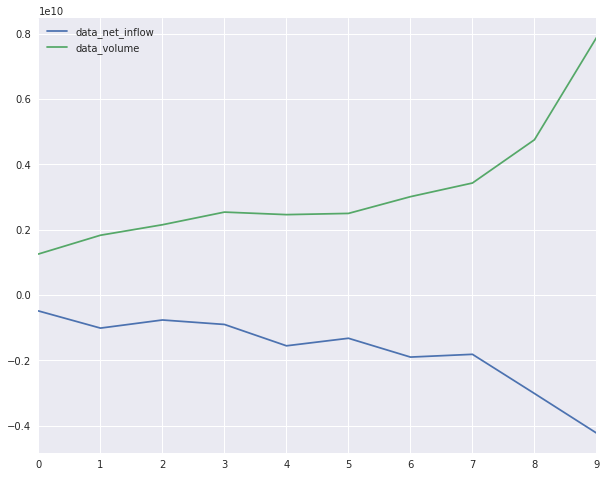

In [6]:
data_total[['data_net_inflow','data_volume']].plot(figsize=(10,8))

### **3.2 不同市值分组下的资金净流入和成交量展示图**

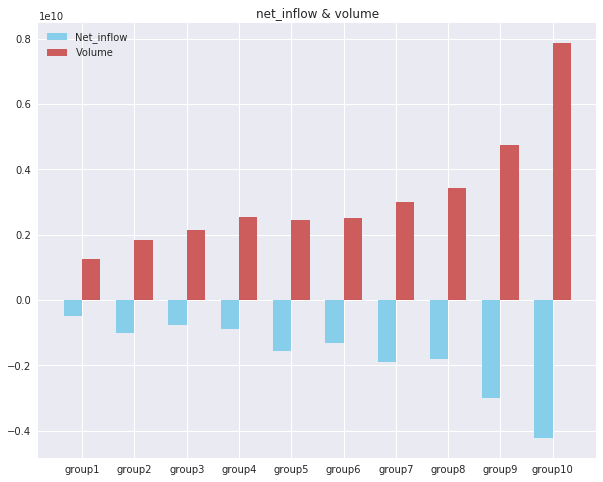

In [7]:
ind = np.arange(len(data_total['data_net_inflow'])) 
width = 0.35

fig,ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(ind - width/2, data_total['data_net_inflow'], width, color='SkyBlue', label='Net_inflow')
rects2 = ax.bar(ind + width/2, data_total['data_volume'], width,color='IndianRed', label='Volume')

ax.set_title('net_inflow & volume')
plt.xticks(ind,('group1', 'group2', 'group3', 'group4', 'group5','group6','group7','group8','group9','group10'))
ax.legend()

In [8]:
data_total.loc['Col_sum'] = data_total.apply(lambda x: x.sum())
data_total

,data_factor,data_net_inflow,data_volume
0,4.776260e+11,-4.869376e+08,1.257051e+09
1,6.446934e+11,-1.012772e+09,1.832052e+09
2,8.006962e+11,-7.643456e+08,2.153484e+09
3,9.747939e+11,-9.009924e+08,2.541013e+09
4,1.179759e+12,-1.555130e+09,2.463412e+09
5,1.447312e+12,-1.324253e+09,2.500842e+09
6,1.927586e+12,-1.900550e+09,3.013475e+09
7,2.735843e+12,-1.816132e+09,3.432070e+09
8,4.709769e+12,-3.016223e+09,4.757325e+09
9,2.866271e+13,-4.227482e+09,7.884248e+09


In [9]:
data_total['inflow_by_volume']=data_total['data_net_inflow']/data_total['data_volume']
data_total

,data_factor,data_net_inflow,data_volume,inflow_by_volume
0,4.776260e+11,-4.869376e+08,1.257051e+09,-0.387365
1,6.446934e+11,-1.012772e+09,1.832052e+09,-0.552808
2,8.006962e+11,-7.643456e+08,2.153484e+09,-0.354934
3,9.747939e+11,-9.009924e+08,2.541013e+09,-0.354580
4,1.179759e+12,-1.555130e+09,2.463412e+09,-0.631291
5,1.447312e+12,-1.324253e+09,2.500842e+09,-0.529523
6,1.927586e+12,-1.900550e+09,3.013475e+09,-0.630684
7,2.735843e+12,-1.816132e+09,3.432070e+09,-0.529165
8,4.709769e+12,-3.016223e+09,4.757325e+09,-0.634017
9,2.866271e+13,-4.227482e+09,7.884248e+09,-0.536193


### **3.3 剔除长期偏好的资金流动强度**

In [10]:
mean_overinflow=data_total.ix[0:10,'inflow_by_volume'].sum()-data_total.ix[10,'inflow_by_volume']*10
var_f=0
for i in range(10):
    dev=data_total.ix[i,'inflow_by_volume']-data_total.ix[10,'inflow_by_volume']-mean_overinflow
    var_f+=pow(dev,2)*(data_total.ix[i,'data_factor']/data_total.ix[10,'data_factor'])
    
std_f=math.sqrt(var_f)
print(std_f)

0.2183871088326275


## **4.时间窗口内的资金流动强度**

In [11]:
start_date='2018-01-10'
end_date='2019-01-10'

start_date=datetime.datetime.strptime(start_date,'%Y-%m-%d')
end_date=datetime.datetime.strptime(end_date,'%Y-%m-%d')+datetime.timedelta(days=1)

flag=True

def inflow(stock_list,start_date):
    
    for stock in stock_list:
        #print(stock)
        data_buy=get_money_flow_step(security_list=stock,start_date=None,end_date=start_date,fre_step='1d',\
        fields=['act_buy_xl','act_buy_l','act_buy_m'],count=1,is_panel=0)[stock]
 
        data_sell=get_money_flow_step(security_list=stock,start_date=None,end_date=start_date,fre_step='1d',\
        fields=['act_sell_xl','act_sell_l','act_sell_m'],count=1,is_panel=0)[stock]
        
        data_buyall=pd.DataFrame(data_buy.apply(lambda x:x.sum(),axis=1),columns=['buy_all'])
        data_sellall=pd.DataFrame(data_sell.apply(lambda x:x.sum(),axis=1),columns=['sell_all'])
        data_all=pd.concat([data_buyall,data_sellall],axis=1) 
        data_net=data_all['buy_all']-data_all['sell_all']
        try:
            data_net=pd.Series(data_net[0],index=[stock])
        except:
            continue
        
        if 'inflow_df' in locals():
            inflow_df = inflow_df.append(data_net)
        else:
            inflow_df = data_net
    inflow_df=inflow_df.to_frame()
    inflow_df.columns=['net_inflow']

    return inflow_df


#标准化
def zscore(factor, df):
    mean = df[factor].mean()
    std = df[factor].std()
    df = (df - mean) / std
    return df 
    
    
while start_date<end_date: 
    #print(start_date)
    stock_list=list(get_index_stocks('000300.SH',date=start_date))
    
    #取全市场股票各股票市值因子
    df = get_fundamentals(query(asharevalue.symbol, asharevalue.total_mv).filter(\
                        asharevalue.symbol.in_(stock_list)).order_by(asharevalue.total_mv.asc()),date=start_date)
    df.set_index('asharevalue_symbol',inplace=True)
    df.index.name='symbol'
    
    #取全市场股票各股票流入净值
    df_inflow=inflow(stock_list,start_date)
    
    #取全市场股票各股票成交量
    df_volume = get_price(stock_list, None, '20170303', '1d', ['volume'], True, None, 1, is_panel=1)['volume']
    df_volume=df_volume.T
    df_volume.columns=['df_volume']
    
    #合并三表
    df=pd.concat([df,df_inflow,df_volume],axis=1)
    
    #按照市值排序
    df.sort_values(by='asharevalue_total_mv',ascending = True,inplace=True)
    df.dropna(inplace=True)
    df_slice=round(len(df)/10)
    #print(df)
    
    #将dataframe的净流入和成交量分成10份切片，并在切片内进行加总
    data_net_inflow=[]
    data_volume=[]
    data_factor=[]
    for i in range(10):
        data_sum=df.ix[i*df_slice:(i+1)*df_slice,['asharevalue_total_mv','net_inflow','df_volume']].apply(lambda x: x.sum())
        data_net_inflow.append(data_sum['net_inflow'])
        data_volume.append(data_sum['df_volume'])
        data_factor.append(data_sum['asharevalue_total_mv'])
    
    data_net_inflow=pd.Series(data_net_inflow)
    data_volume=pd.Series(data_volume)
    data_factor=pd.Series(data_factor)
    
    data_total=pd.DataFrame([data_factor,data_net_inflow,data_volume])
    data_total=data_total.T
    data_total.columns=['data_factor','data_net_inflow','data_volume']
    data_total.loc['Col_sum'] = data_total.apply(lambda x: x.sum())
    data_total['inflow_by_volume']=data_total['data_net_inflow']/data_total['data_volume']
    
    mean_overinflow=data_total.ix[0:10,'inflow_by_volume'].sum()-data_total.ix[10,'inflow_by_volume']*10
    
    var_f=0
    for i in range(10):
        dev=data_total.ix[i,'inflow_by_volume']-data_total.ix[10,'inflow_by_volume']-mean_overinflow
        var_f+=pow(dev,2)*(data_total.ix[i,'data_factor']/data_total.ix[10,'data_factor'])
    
    std_f=math.sqrt(var_f)
    std_f_frame=pd.DataFrame([std_f],index=[start_date])

    
    #合并时间窗口的流动强度数据
    if flag:
        flag=False
        std_total = std_f_frame
    else:
        std_total = std_total.append(std_f_frame)
    
    print(start_date)
    start_date+=datetime.timedelta(days=1)
    
std_total.dropna(inplace=True)
std_total.columns=['std_flow']

new_std_total=zscore('std_flow',std_total)
     

2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-24 00:00:00
2018-02-25 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00


### **4.1 标准化处理过的资金流动强度**

In [12]:
new_std_total.head()

,std_flow
2018-01-10,2.711643
2018-01-11,-0.775624
2018-01-12,1.912241
2018-01-15,2.579242
2018-01-16,1.852556


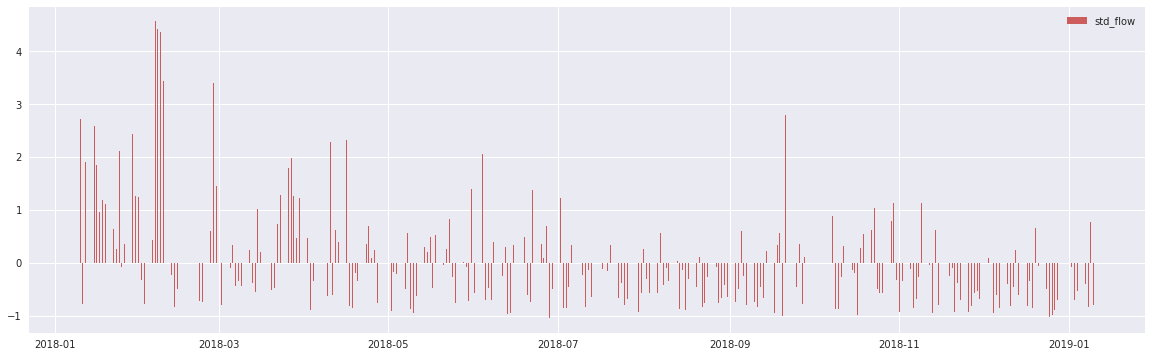

In [19]:
new_std_total.index=pd.to_datetime(new_std_total.index)
ind = new_std_total.index
width = 0.35 
fig, ax = plt.subplots(figsize=(20,6))
rects1=ax.bar(ind, new_std_total['std_flow'], width, color='IndianRed', label='std_flow')
ax.legend()
plt.show()

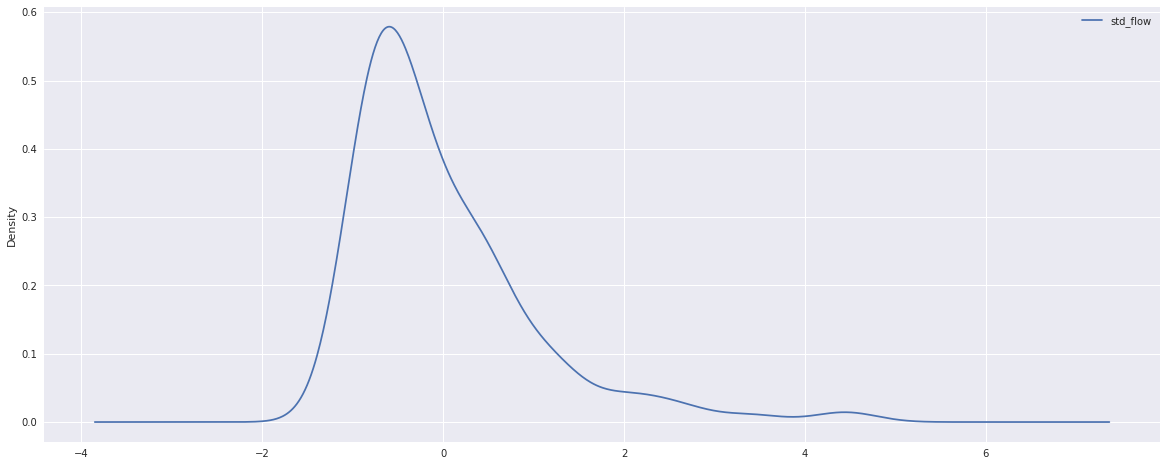

In [20]:
fig = plt.figure(figsize = (20, 8))
ax = new_std_total['std_flow'].plot.kde(label = 'std_flow')
ax.legend()

### **4.2 市值风格下的涨跌幅**

In [18]:
flag1=True

start_date1='2018-01-10'
end_date1='2019-01-10'

start_date=datetime.datetime.strptime(start_date1,'%Y-%m-%d')
end_date=datetime.datetime.strptime(end_date1,'%Y-%m-%d')+datetime.timedelta(days=1)

while start_date<end_date: 
    next_date=start_date+datetime.timedelta(days=1)
    #print(next_date)
    
    stock_list=list(get_index_stocks('000300.SH',date=start_date))
    
    #取全市场股票各股票市值因子
    df = get_fundamentals(query(asharevalue.symbol, asharevalue.total_mv).filter(\
                        asharevalue.symbol.in_(stock_list)).order_by(asharevalue.total_mv.asc()),date=start_date)
    df.set_index('asharevalue_symbol',inplace=True)
    df.index.name='symbol'
    
    stocklist_cap_top=list(df[:int(len(df)*0.1)].index)
    stocklist_cap_bottom=list(df[int(len(df)*0.9):].index)
    #print(stocklist_cap_top)
    #print(stocklist_cap_bottom)
    
    try:
        value_top = get_price(stocklist_cap_top,None, start_date, '1d', \
                              ['quote_rate'],True, None,1,is_panel=1)['quote_rate']
        return_sum_top=value_top.apply(lambda x:x.mean(),axis=1)    
        
        value_bottom = get_price(stocklist_cap_bottom,None, start_date, '1d', \
                                 ['quote_rate'], True, None,1,is_panel=1)['quote_rate']
        return_sum_bottom=value_bottom.apply(lambda x:x.mean(),axis=1) 

        
    except:
        start_date=start_date+datetime.timedelta(days=1)
        continue
        
    #print(return_sum)
    
    
    if flag1:
        flag1=False
        return_date_total_top = return_sum_top
        return_date_total_bottom=return_sum_bottom
    else:
        return_date_total_top = return_date_total_top.append(return_sum_top)
        return_date_total_bottom = return_date_total_bottom.append(return_sum_bottom)
    
    start_date=start_date+datetime.timedelta(days=1)


In [21]:
return_date_total_top=return_date_total_top.to_frame()
return_date_total_top.columns=['return_daily_top']
return_date_total_bottom=return_date_total_bottom.to_frame()
return_date_total_bottom.columns=['return_daily_bottom']
return_date_total_bottom.head()

,return_daily_bottom
2018-01-10,1.566003
2018-01-11,0.002963
2018-01-12,0.968620
2018-01-15,1.316387
2018-01-16,0.259030


In [46]:
#合并风格涨跌幅表和风格下资金流动强度表
data_return_stdflow=pd.concat([new_std_total,return_date_total_top,return_date_total_bottom],axis=1)
data_return_stdflow.head()

,std_flow,return_daily_top,return_daily_bottom
2018-01-10,2.711643,-0.973173,1.566003
2018-01-11,-0.775624,0.047317,0.002963
2018-01-12,1.912241,-0.553447,0.968620
2018-01-15,2.579242,-3.239903,1.316387
2018-01-16,1.852556,0.428570,0.259030


### **4.3 Top市值风格涨跌幅与资金流入强度关系图**

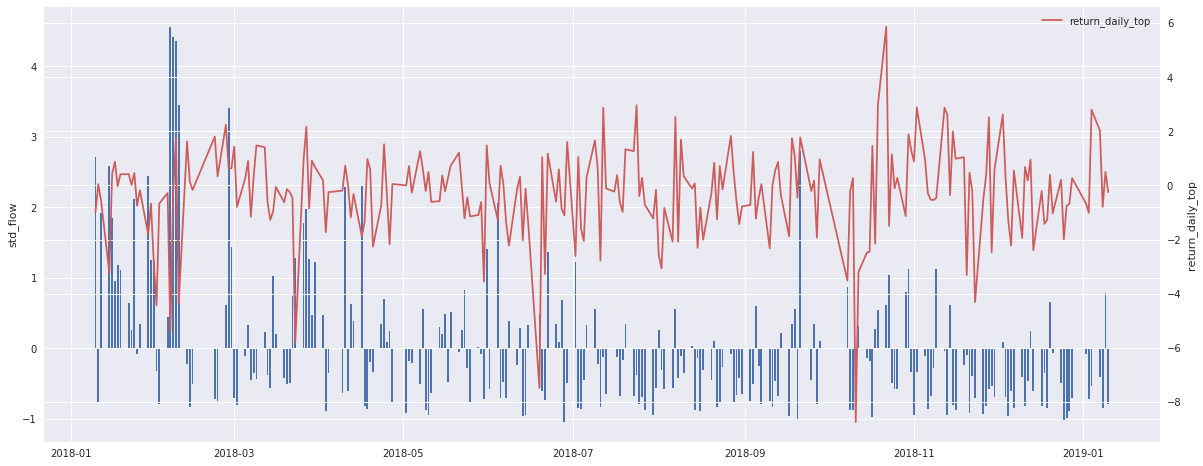

In [47]:
data_return_stdflow_copy=data_return_stdflow
data_return_stdflow_copy.index=pd.to_datetime(data_return_stdflow_copy.index)
ind = data_return_stdflow_copy.index
width = 0.65
fig, ax = plt.subplots(figsize=(20,8))
rects1=ax.bar(ind, data_return_stdflow_copy['std_flow'], width,  label='std_flow')
ax.set_ylabel('std_flow')
ax=ax.twinx()
rects2 = ax.plot(ind,data_return_stdflow_copy['return_daily_top'],color='IndianRed')
ax.set_ylabel('return_daily_top')
ax.legend()
plt.show()

### **4.4 Bottom市值风格涨跌幅与资金流入强度关系图**

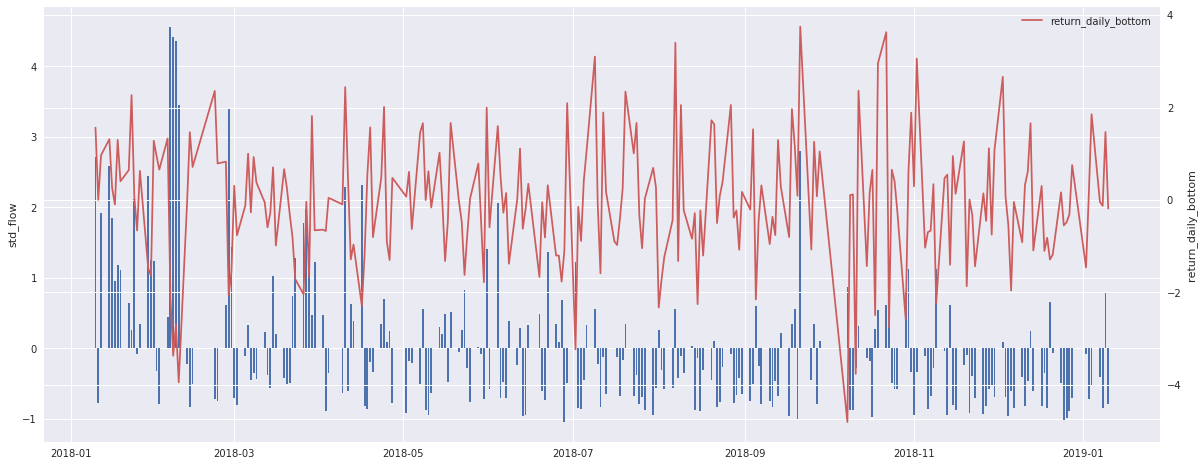

In [48]:
data_return_stdflow_copy.index=pd.to_datetime(data_return_stdflow_copy.index)
ind = data_return_stdflow_copy.index
width = 0.65
fig, ax = plt.subplots(figsize=(20,8))
rects1=ax.bar(ind, data_return_stdflow_copy['std_flow'], width,  label='std_flow')
ax.set_ylabel('std_flow')
ax=ax.twinx()
rects2 = ax.plot(ind,data_return_stdflow_copy['return_daily_bottom'],color='IndianRed')
ax.set_ylabel('return_daily_bottom')
ax.legend()
plt.show()

## **5. 资金流入强度与风格下股票组合涨跌幅相关性**

In [49]:
for days in range(1,6):
    data_return_stdflow_copy['std_flow_pre%dd'%days]=data_return_stdflow_copy['std_flow'].shift(days)  
    data_return_stdflow_copy.dropna(inplace=True)
data_return_stdflow_copy.head()

,std_flow,return_daily_top,return_daily_bottom,std_flow_pre1d,std_flow_pre2d,std_flow_pre3d,std_flow_pre4d,std_flow_pre5d
2018-01-31,1.239100,-2.833323,1.281957,1.258554,2.440805,0.348983,-0.077692,2.120032
2018-02-01,-0.324186,-4.429560,0.954830,1.239100,1.258554,2.440805,0.348983,-0.077692
2018-02-02,-0.785630,-0.661970,0.658227,-0.324186,1.239100,1.258554,2.440805,0.348983
2018-02-05,0.438010,-0.280377,1.333043,-0.785630,-0.324186,1.239100,1.258554,2.440805
2018-02-06,4.561510,-5.433270,-2.090997,0.438010,-0.785630,-0.324186,1.239100,1.258554


### **5.1 选取标准化后资金流入强度 >1.96**

In [50]:
data_return_stdflow_select=data_return_stdflow_copy[data_return_stdflow_copy['std_flow_pre1d']>1.96]
data_return_stdflow_select.head()

,std_flow,return_daily_top,return_daily_bottom,std_flow_pre1d,std_flow_pre2d,std_flow_pre3d,std_flow_pre4d,std_flow_pre5d
2018-02-07,4.418203,-0.236470,-3.370983,4.561510,0.438010,-0.785630,-0.324186,1.239100
2018-02-08,4.364126,1.742569,-2.693657,4.418203,4.561510,0.438010,-0.785630,-0.324186
2018-02-09,3.445064,-4.361552,-3.945407,4.364126,4.418203,4.561510,0.438010,-0.785630
2018-02-12,-0.228793,1.627772,-0.072117,3.445064,4.364126,4.418203,4.561510,0.438010
2018-02-28,1.443578,0.639150,-1.548810,3.406240,0.607778,-0.752558,-0.724143,-0.505014


### **5.2 风格下资金流入强度与风格组合后一日涨跌幅的相关性**
#### 1. 前一日资金流入强度

In [52]:
corr_1=data_return_stdflow_select[['return_daily_top','return_daily_bottom','std_flow_pre1d','std_flow']].corr()
corr_1

,return_daily_top,return_daily_bottom,std_flow_pre1d,std_flow
return_daily_top,1.000000,0.518051,-0.085800,-0.166893
return_daily_bottom,0.518051,1.000000,-0.769177,-0.884400
std_flow_pre1d,-0.085800,-0.769177,1.000000,0.852448
std_flow,-0.166893,-0.884400,0.852448,1.000000


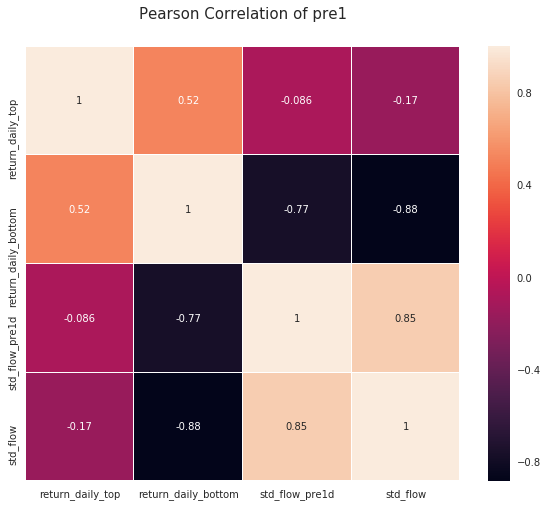

In [61]:
import seaborn
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of pre1',y=1.05,size=15)
seaborn.heatmap(data_return_stdflow_select[['return_daily_top','return_daily_bottom','std_flow_pre1d','std_flow']].astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.show()

#### 2. 前第二日资金流入强度

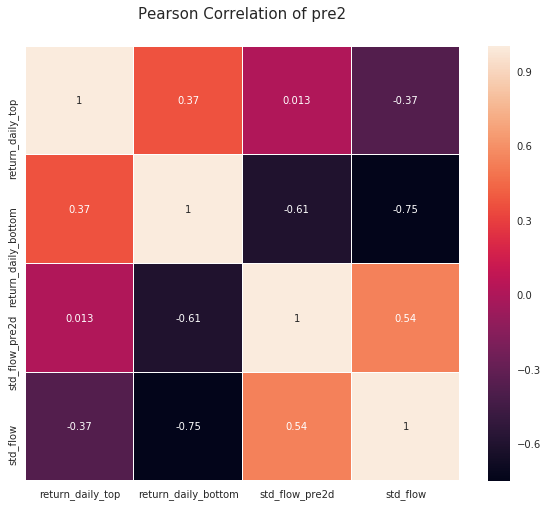

In [63]:
data_return_stdflow_select2=data_return_stdflow_copy[data_return_stdflow_copy['std_flow_pre2d']>1.96]

plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of pre2',y=1.05,size=15)
seaborn.heatmap(data_return_stdflow_select2[['return_daily_top','return_daily_bottom','std_flow_pre2d','std_flow']].astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.show()

#### 3. 前第三日资金流入强度

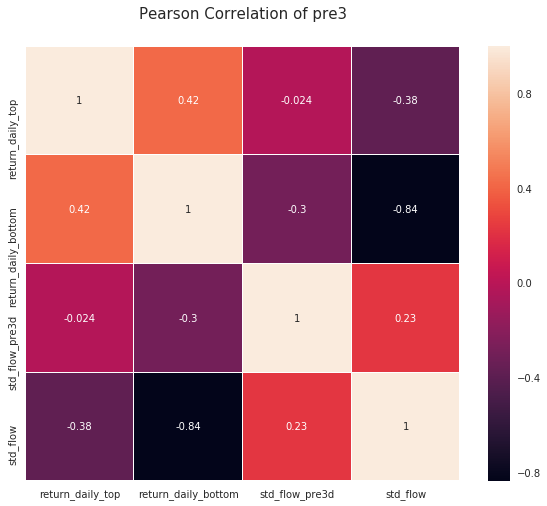

In [67]:
data_return_stdflow_select3=data_return_stdflow_copy[data_return_stdflow_copy['std_flow_pre3d']>1.96]

plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of pre3',y=1.05,size=15)
seaborn.heatmap(data_return_stdflow_select3[['return_daily_top','return_daily_bottom','std_flow_pre3d','std_flow']].astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.show()

#### 4. 前第四日资金流入强度

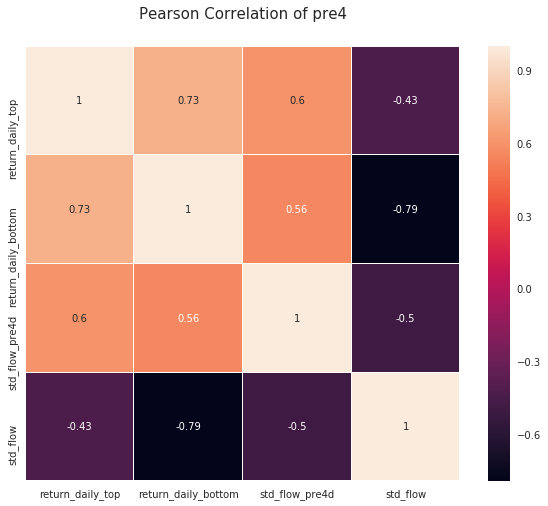

In [68]:
data_return_stdflow_select4=data_return_stdflow_copy[data_return_stdflow_copy['std_flow_pre4d']>1.96]

plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of pre4',y=1.05,size=15)
seaborn.heatmap(data_return_stdflow_select4[['return_daily_top','return_daily_bottom','std_flow_pre4d','std_flow']].astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.show()

#### 5. 前第五日资金流入强度

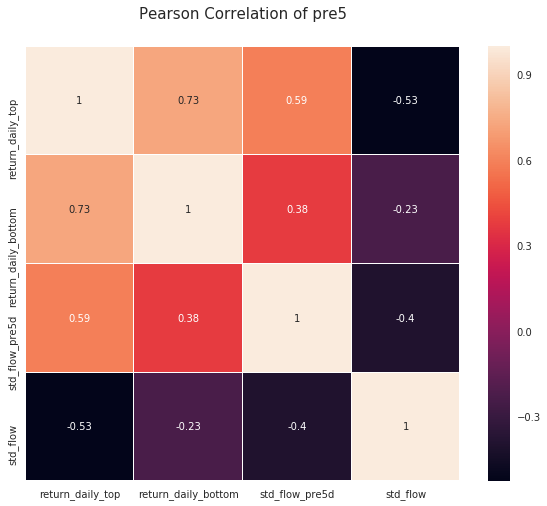

In [69]:
data_return_stdflow_select5=data_return_stdflow_copy[data_return_stdflow_copy['std_flow_pre5d']>1.96]

plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of pre5',y=1.05,size=15)
seaborn.heatmap(data_return_stdflow_select5[['return_daily_top','return_daily_bottom','std_flow_pre5d','std_flow']].astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.show()